In [4]:
import sklearn
import matplotlib.pyplot as plt
import numpy as np
from sklearn.preprocessing import StandardScaler, MultiLabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, hamming_loss
from sklearn.feature_selection import SequentialFeatureSelector
from sklearn.ensemble import RandomForestClassifier
from db import get_data_osu_db

names, X, y = get_data_osu_db()
X_train, X_test, y_train, y_test, names_train, names_test = train_test_split(X, y, names, test_size=0.3, random_state=0)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)
mul = MultiLabelBinarizer()
y_train_bin = mul.fit_transform(y_train)
y_test_bin = mul.transform(y_test)
clf = RandomForestClassifier(n_estimators=10, random_state=0)
clf.fit(X_train_scaled, y_train_bin)
print('Average fraction of incorrect labels: ', hamming_loss(clf.predict(X_test_scaled), y_test_bin))

Average fraction of incorrect labels:  0.175


OverallDifficulty 0.11873402381738926
AvgNoteDist 0.10220803753243565
MapLength 0.10120784107145836
MapDensity 0.09017668381708425
AvgBPM 0.08416871557531176
SliderMultiplier 0.08022384511879342
ApproachRate 0.07363630970816092
SliderObjectRatio 0.06694024240135407
AvgSliderVelocity 0.05993806066108604
CircleSize 0.05469876155486052
FlowAimDensity 0.04658477605095013
SpacedStreamDensity 0.04259817866586068
SliderTickRate 0.03233150478324856
BurstDensity 0.029377875388383722
StreamDensity 0.017175143853622787


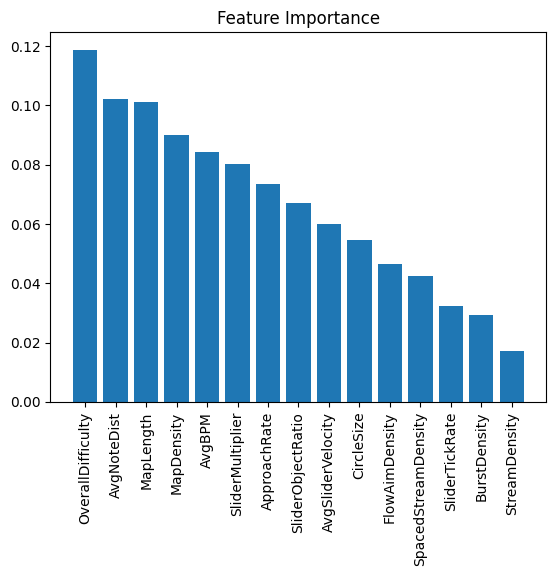

In [5]:
from assets import mapFeatureDetails

importances = clf.feature_importances_
indices = np.argsort(importances)[::-1]
for f in range(X_train_scaled.shape[1]):
    print(mapFeatureDetails[indices[f]], importances[indices[f]])

plt.title('Feature Importance')
plt.bar(range(X_train_scaled.shape[1]), importances[indices], align='center')
plt.xticks(range(X_train_scaled.shape[1]), np.array(mapFeatureDetails)[indices], rotation=90)
plt.show()


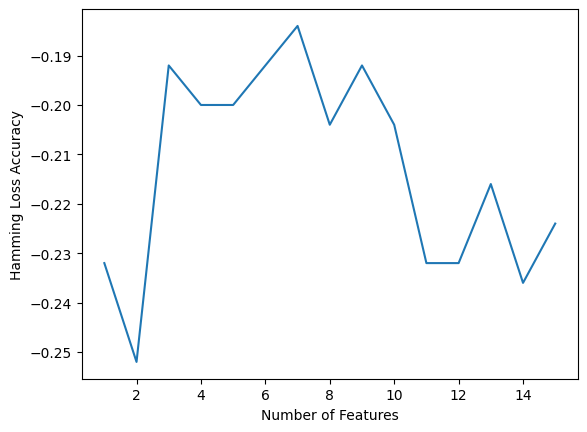

In [6]:
from sklearn.feature_selection import SequentialFeatureSelector
from sklearn.model_selection import cross_val_score
from sklearn.metrics import make_scorer, hamming_loss

scores = []
hamming_scorer = make_scorer(hamming_loss, greater_is_better=False)
for k in range(1, X_train_scaled.shape[1]):
    sfs = SequentialFeatureSelector(clf, n_features_to_select=k, direction='forward', scoring=hamming_scorer)
    sfs.fit(X_train_scaled, y_train_bin)
    selected_features = sfs.get_support()
    score = cross_val_score(clf, X_train_scaled[:, selected_features], y_train_bin, scoring=hamming_scorer).mean()
    scores.append(score)
all_selected_score = cross_val_score(clf, X_train_scaled, y_train_bin, scoring=hamming_scorer).mean()
scores.append(all_selected_score)
plt.plot(range(1, X_train_scaled.shape[1] + 1), scores)
plt.xlabel('Number of Features')
plt.ylabel('Hamming Loss Accuracy')
plt.show()

In [10]:
from sklearn.feature_selection import SelectFromModel

select = SelectFromModel(clf, max_features=7)
X_train_lim = select.fit_transform(X_train_scaled, y_train_bin)
X_test_lim = select.transform(X_test_scaled)

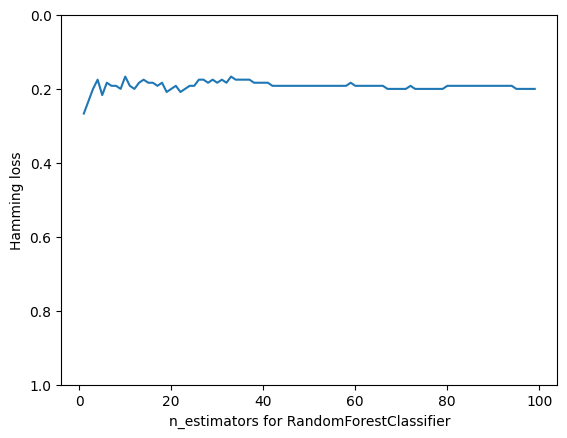

In [11]:
scores = []
for k in range(1, 100):
    clf = RandomForestClassifier(n_estimators=k, max_depth=6, random_state=0)
    clf.fit(X_train_lim, y_train_bin)
    score = hamming_loss(clf.predict(X_test_lim), y_test_bin)
    scores.append(score)
plt.plot(range(1, 100), scores)
plt.ylim(1, 0)
plt.xlabel('n_estimators for RandomForestClassifier')
plt.ylabel('Hamming loss')
plt.show()

In [13]:
from sklearn.linear_model import LogisticRegression
from sklearn.multioutput import MultiOutputClassifier
from sklearn.model_selection import GridSearchCV

param_grid = {
    'estimator__C': [0.01, 0.1, 1, 10, 100],
    'estimator__penalty': ['l1', 'l2'],
    'estimator__solver': ['liblinear'],
}

estimator = LogisticRegression(random_state=0, max_iter=1000)
lr_clf = MultiOutputClassifier(estimator)

gs = GridSearchCV(lr_clf, param_grid, cv=5, scoring=hamming_scorer)
gs.fit(X_train_lim, y_train_bin)
print('Optimal parameters for logistic regression: ', gs.best_params_)

lr_model = gs.best_estimator_

print('Prediction Hamming Loss using Logistic Regression', hamming_loss(lr_model.predict(X_test_lim), y_test_bin))

Optimal parameters for logistic regression:  {'estimator__C': 0.1, 'estimator__penalty': 'l2', 'estimator__solver': 'liblinear'}
Prediction Hamming Loss using Logistic Regression 0.2


In [14]:
from sklearn.svm import SVC

estimator = SVC(random_state=0)
svm_clf = MultiOutputClassifier(estimator)

param_grid = {
    'estimator__C': [0.01, 0.1, 1, 10, 100],
    'estimator__kernel': ['linear', 'rbf', 'poly'],
    'estimator__gamma': ['scale', 'auto', 0.001, 0.01, 0.1, 1],
}
gs = GridSearchCV(svm_clf,  param_grid, cv=3, scoring=hamming_scorer)
gs.fit(X_train_lim, y_train_bin)
print('Optimal parameters for SVM: ', gs.best_params_)

svm_model = gs.best_estimator_
print('Prediction Hamming Loss using SVM', hamming_loss(svm_model.predict(X_test_lim), y_test_bin))

Optimal parameters for SVM:  {'estimator__C': 10, 'estimator__gamma': 0.01, 'estimator__kernel': 'rbf'}
Prediction Hamming Loss using SVM 0.175


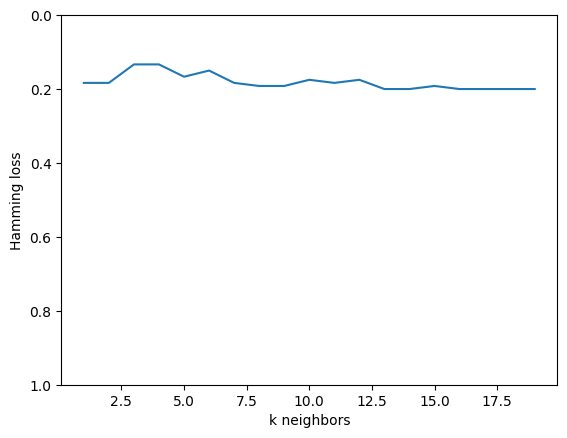

In [15]:
from sklearn.neighbors import KNeighborsClassifier
scores = []
for k in range(1, 20):
    knn = KNeighborsClassifier(n_neighbors=k)
    knn.fit(X_train_lim, y_train_bin)
    score = hamming_loss(knn.predict(X_test_lim), y_test_bin)
    scores.append(score)
plt.plot(range(1, 20), scores)
plt.ylim(1, 0)
plt.xlabel('k neighbors')
plt.ylabel('Hamming loss')
plt.show()